# 加载 `MNIST` 数据集
---

## `MNIST`数据集格式

`MNIST`数据集分为训练集和测试集，训练集中有`60000`条数据，测试集中有`10000`条数据

每个数据集分为**图像**和**标签**

### 图像数据集

图像数据集文件分为文件头和图像数据

文件头共有32个字节(0~31)，每8个字节构成一个32为的整数(大端序)
|地址|0~7|8~15|16~23|24~31|
|----|----|----|----|----|
|数据|2051|图像数量|像素点行数|像素点列数|


图像数据从第32字节位置开始。

图像是一个`28x28`的灰度像素图，每个图的每个像素点由一个`uint8`表示，范围是`0~255`

像素在文件中按行排列，多个行拼成一个完整的图像；图像数据集由一个个图像拼接而成


### 标签数据集

标签数据集用来标识对应图像数据集对应的正确结果，排列顺序与对应的图像数据集完全一致

标签数据集文件分为文件头和标签数据

文件头共16个字节(0~15)，每8个字节构成一个32为的整数(大端序)
|地址|0~7|8~15|
|----|----|----|
|数据|2049|标签数量|

标签数据从第16字节位置开始。

每个标签由一个`uint8`表示，范围是`0~9`

标签数据集由一个个标签拼接而成

---

## 导入数据集过程

In [1]:
from typing import override

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

### 定义`MNIST`数据集

In [2]:
class MnistDataset(Dataset):
    @override
    def __init__(self, x:torch.Tensor, y:torch.Tensor) -> None:
        super().__init__()
        if len(x) != len(y):
            raise IndexError('len(x) != len(y)')
        self.x = x
        self.y = y
        return
    
    @override
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[index], self.y[index]
    
    @override
    def __len__(self) -> int:
        return len(self.x)


### 加载数据集函数

对于图像数据
- 打开文件
- 读取头部信息
- 使用`numpy`加载图像
- 更改数组形状
- 转为Tensor

对于标签数据
- 打开文件
- 读取头部信息
- 使用`numpy`加载标签
- 转为独热码的Tensor

In [3]:
def readDataset(name:str) -> MnistDataset:
    fullImgPath = f'./mnistData/{name}-images.idx3-ubyte'
    fullLabelPath = f'./mnistData/{name}-labels.idx1-ubyte'

    with open(fullImgPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2051:
            raise ValueError(f'head magic number not equal to 2051: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        dataRow = int.from_bytes(f.read(4))
        dataCol = int.from_bytes(f.read(4))
        
        img = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber*dataRow*dataCol,
            offset=0,
            )
    img.shape = (dataNumber,dataRow * dataCol)
    imgTensor = torch.from_numpy(img).type(torch.float32) / 255
        
    with open(fullLabelPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2049:
            raise ValueError(f'head magic number not equal to 2049: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        
        label = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber,
            offset=0,
            )

    labelOnehotTensor = torch.zeros((len(label), 10), dtype=torch.float32)
    for i,j in zip(label, labelOnehotTensor):
        j[i] = 1
    
    return MnistDataset(imgTensor, labelOnehotTensor)


## 尝试加载数据集

tensor(2)


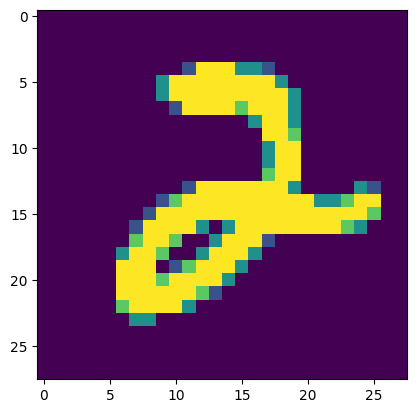

tensor(8)


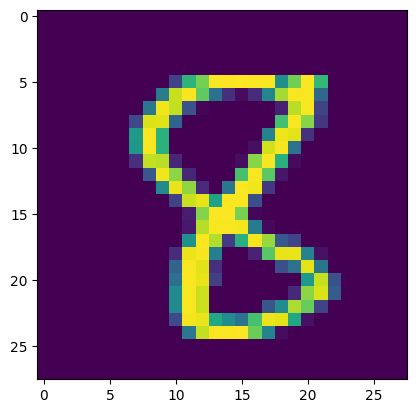

tensor(8)


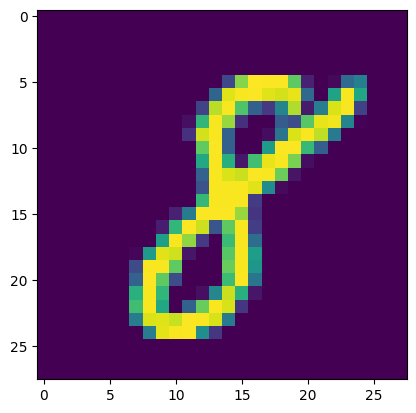

tensor(1)


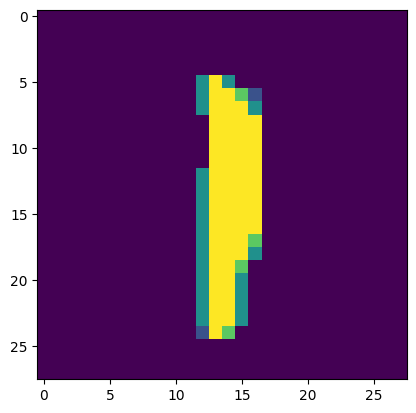

tensor(0)


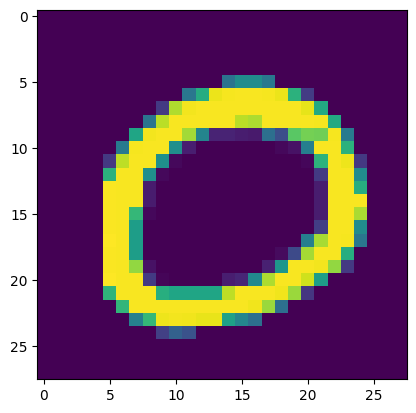

tensor(0)


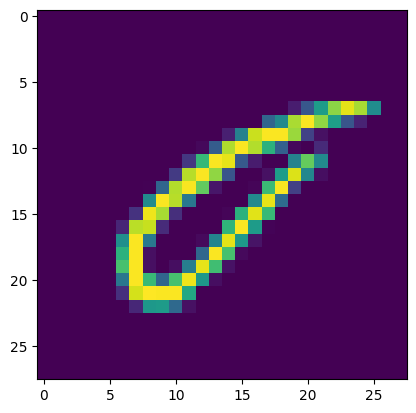

tensor(3)


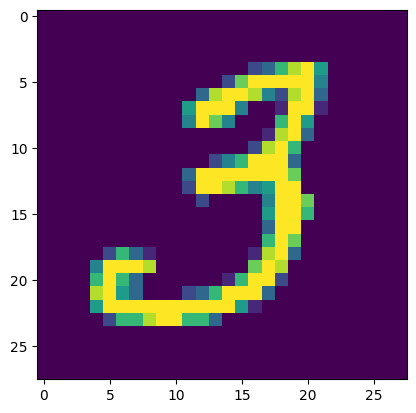

tensor(3)


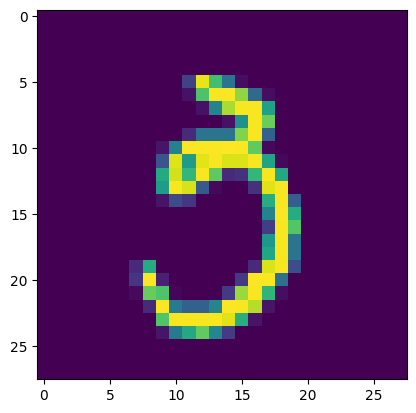

tensor(7)


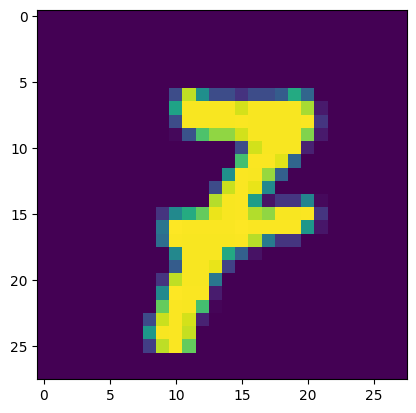

tensor(0)


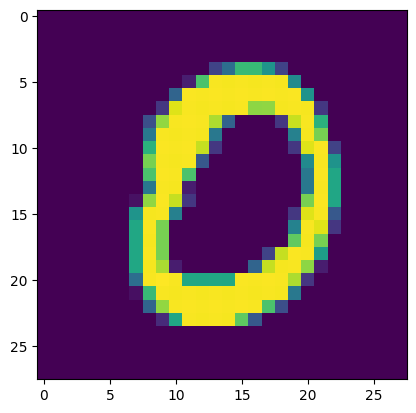

In [4]:
trainSet = readDataset('train')
trainDataLoader = DataLoader(trainSet, 10, True)

for data in trainDataLoader:
    imgs = data[0]
    labels = data[1]

    for img,label in zip(imgs, labels):
        print(label.argmax())
        plt.imshow(img.reshape((28,28)))
        plt.show()
    break
